In [1]:
try:
    import google.colab
    IN_COLAB = True
    from tqdm.notebook import tqdm, trange

    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    %cd /content/gdrive/MyDrive/feature-circuits
    %pip install -r requirements.txt
except:
    IN_COLAB = False
    from tqdm import tqdm, trange

import os

import torch
from nnsight import LanguageModel

from circuit_ import get_circuit
from circuit_plotting import plot_circuit
from dictionary_learning import AutoEncoder

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("DEVICE :", DEVICE)

print("IN_COLAB :", IN_COLAB)

c:\Users\ConnardMcGregoire\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE : cuda:0
IN_COLAB : False


In [2]:
pythia70m = LanguageModel("EleutherAI/pythia-70m-deduped", device_map=DEVICE, dispatch=True)

pythia70m_embed = pythia70m.gpt_neox.embed_in

pythia70m_resids= []
pythia70m_attns = []
pythia70m_mlps = []
for layer in range(len(pythia70m.gpt_neox.layers)):
    pythia70m_resids.append(pythia70m.gpt_neox.layers[layer])
    pythia70m_attns.append(pythia70m.gpt_neox.layers[layer].attention)
    pythia70m_mlps.append(pythia70m.gpt_neox.layers[layer].mlp)

c:\Users\ConnardMcGregoire\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
if IN_COLAB:
    base = "/content/gdrive/MyDrive/feature-circuits/"
else:
    base = "C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/"
path = base + "dictionary_learning/dictionaires/pythia-70m-deduped/"

if not os.path.exists(path):
    if IN_COLAB:
        # go to base / dictionary_learning :
        %cd /content/gdrive/MyDrive/feature-circuits/dictionary_learning
        !apt-get update
        !apt-get install dos2unix
        !dos2unix pretrained_dictionary_downloader.sh
        !chmod +x pretrained_dictionary_downloader.sh
        !./pretrained_dictionary_downloader.sh
        %cd /content/gdrive/MyDrive/feature-circuits
    else:
        %cd C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/dictionary_learning
        %run ./pretrained_dictionary_downloader.sh
        %cd C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits

dictionaries = {}

d_model = 512
dict_size = 32768

ae = AutoEncoder(d_model, dict_size).to(DEVICE)
ae.load_state_dict(torch.load(path + f"embed/ae.pt", map_location=DEVICE))
dictionaries[pythia70m_embed] = ae


for layer in range(len(pythia70m.gpt_neox.layers)):
    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(torch.load(path + f"resid_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_resids[layer]] = ae

    # ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    # ae.load_state_dict(torch.load(path + f"attn_out_layer{layer}/ae.pt", map_location=DEVICE))
    # dictionaries[pythia70m_attns[layer]] = ae

    # ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    # ae.load_state_dict(torch.load(path + f"mlp_out_layer{layer}/ae.pt", map_location=DEVICE))
    # dictionaries[pythia70m_mlps[layer]] = ae

In [4]:
def metric_fn_v1(model, trg=None):
    """
    default : return the logit
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,-1,:]
    return logits[torch.arange(trg.numel()), trg]

def metric_fn_v2(model, trg=None):
    """
    Return -log probability for the expected target.

    trg : torch.Tensor, contains idxs of the target tokens (between 0 and d_vocab_out)

    /!\ here we assume that all last tokens are indeed in the last position (if padding, it must happen in front of the sequence, not after)
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,-1,:]
    return (
         -1 * torch.gather(
             torch.nn.functional.log_softmax(model.embed_out.output[:,-1,:], dim=-1),
             dim=-1, index=trg.view(-1, 1)
         ).squeeze(-1)
    )

In [5]:
batch_size = 1

clean = [
    "When Mary and John went to the store, John gave a drink to"
    for _ in range(batch_size)
]
patch = None

trg = " Mary"
trg_idx = torch.tensor([pythia70m.tokenizer.encode(trg)[0]] * batch_size, device=DEVICE)
print(trg_idx)

tensor([6393], device='cuda:0')


In [57]:
circuit = get_circuit(
    clean, patch,
    pythia70m,
    pythia70m_embed, pythia70m_resids,
    dictionaries,
    metric_fn_v1, {"trg": trg_idx},
    edge_threshold=0.1
)

Layer 5 : 0.7633986473083496 seconds
Now processing layer 5 with 16 features
[428036, 430366, 432770, 435103, 437083, 444575, 445946, 449138, 449642, 451439, 452071, 454500, 457443, 458717, 458737, 458765]
Layer 4 : 3.0952515602111816 seconds
Now processing layer 4 with 26 features
[98306, 294920, 327689, 360458, 393227, 415569, 425996, 428061, 428435, 429293, 429936, 430930, 431298, 431990, 435238, 437160, 439282, 441790, 443402, 445910, 447609, 454705, 455091, 455319, 455403, 458765]
Layer 3 : 4.237291097640991 seconds
Now processing layer 3 with 67 features
[1812, 5355, 7254, 20526, 26944, 28538, 29679, 32768, 64222, 65537, 66224, 67682, 67867, 70776, 71011, 71187, 74937, 75555, 77333, 80179, 81645, 84387, 85096, 87690, 98306, 109747, 136994, 163844, 182311, 273810, 274509, 277520, 280876, 284594, 294920, 302598, 306361, 309562, 310590, 327689, 342331, 360458, 365993, 379505, 382856, 393227, 401058, 401749, 403650, 405585, 407780, 415383, 419811, 424979, 425996, 433080, 435629, 4365

In [7]:
print(circuit)

({'y': None, 'resid_5': torch.Size([1, 14, 32768]), 'resid_4': torch.Size([1, 14, 32768]), 'resid_3': torch.Size([1, 14, 32768]), 'resid_2': torch.Size([1, 14, 32768]), 'resid_1': torch.Size([1, 14, 32768]), 'resid_0': torch.Size([1, 14, 32768]), 'embed': torch.Size([1, 14, 32768])}, defaultdict(<function get_circuit.<locals>.<lambda> at 0x0000018B350E7CE0>, {'resid_5': {'y': tensor(indices=tensor([[   64,   295,  1333,  1620,  1776,  2039,  2572,  2638,
                         3817,  4369,  4716,  5016,  5239,  5273,  6773,  6827,
                         6878,  7173,  7339,  7389,  7541,  7556,  8042,  8201,
                         8564,  9007,  9106,  9251, 10167, 10426, 11086, 11585,
                        11608, 11959, 12173, 12448, 12549, 13142, 13808, 13893,
                        14088, 14211, 15950, 16077, 16160, 16268, 16822, 16908,
                        17109, 17470, 17829, 18578, 18846, 18943, 19949, 20076,
                        20270, 20827, 21452, 21892, 23141, 23

- cpu :
    - 1 : 2m47
    - 2 : /
    - 10: Stop at 68m+

- gpu :
    - 1 : 42s
    - 2 : 1m32

100%|██████████| 92/92 [02:46<00:00,  1.81s/it]


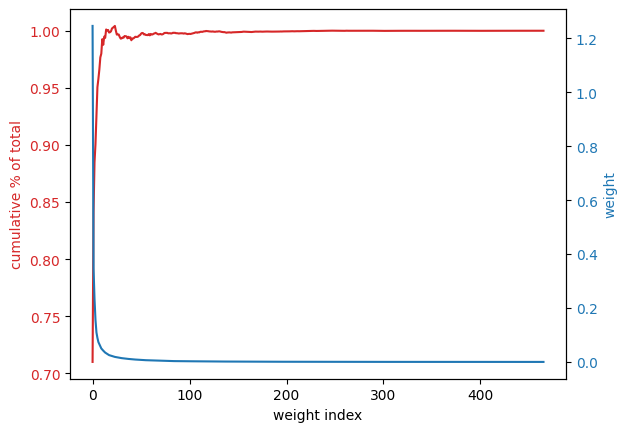

In [63]:
submod_1 = "resid_0"
submod_2 = "resid_1"

weights = circuit[1][submod_1][submod_2]
weights = weights.values()

from matplotlib import pyplot as plt

alive_downstream = circuit[1][submod_1][submod_2].indices()[0]
set_downstream = list(set([alive_downstream_.item() for alive_downstream_ in alive_downstream]))

ss = []
abss = []
nb_k = []

from tqdm import tqdm

for k in tqdm(set_downstream):
    weights = []
    for i, idx in enumerate(alive_downstream):
        if idx == k:
            weights.append(circuit[1][submod_1][submod_2].values()[i])
    weights = torch.stack(weights)

    perm = torch.argsort(weights.abs(), descending=True)
    weights = weights[perm]
    tot = sum(weights)
    s = 0
    for i in range(len(weights)):
        s += weights[i]
        if i < len(ss):
            ss[i] += (s / tot).item()
        else:
            ss.append((s / tot).item())
        if i < len(abss):
            abss[i] += weights[i].abs().item()
        else:
            abss.append(weights[i].abs().item())
        if i < len(nb_k):
            nb_k[i] += 1
        else:
            nb_k.append(1)
        # print("i :", i)
        # print("weight :", embed_weights[i].item())
        # print("% of total :", s.item() / tot.item() * 100)

ss = [ss[i] / nb_k[i] for i in range(len(ss))]
abss = [abss[i] / nb_k[i] for i in range(len(abss))]

"""
plot ss and abss on two different axis with the same x-axis on the same plot
"""
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('weight index')
ax1.set_ylabel('cumulative % of total', color=color)
ax1.plot(ss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('weight', color=color)
ax2.plot(abss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

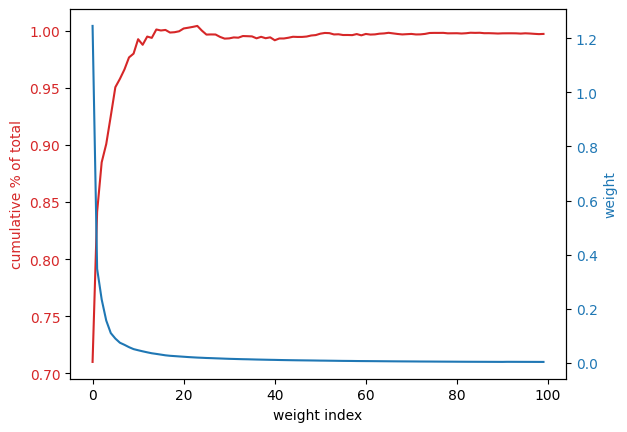

In [61]:
max_weights = 100

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('weight index')
ax1.set_ylabel('cumulative % of total', color=color)
ax1.plot(ss[:max_weights], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('weight', color=color)
ax2.plot(abss[:max_weights], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [64]:
import importlib
import circuit_plotting
importlib.reload(circuit_plotting)
circuit_plotting.plot_circuit(circuit[0], circuit[1], save_dir='./circuit/cpu_2_')

AttributeError: 'torch.Size' object has no attribute 'to_tensor'

torch.Size([146198])
tensor(0.0037, device='cuda:0')


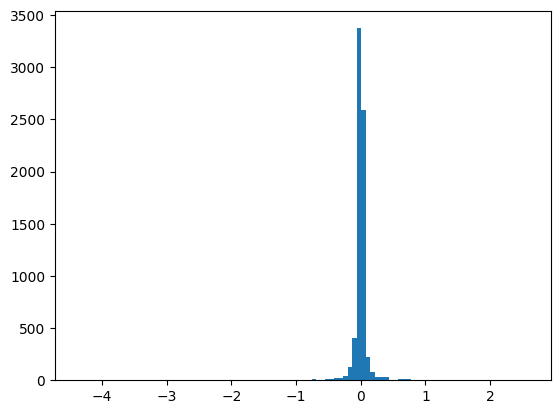

In [ ]:
all_weights = []
for key, value in circuit[1].items():
    for k, v in value.items():
        all_weights.append(v.values())
        
all_weights = torch.cat(all_weights, dim=0)
print(all_weights.shape)
print(all_weights.abs().mean())

plt.hist(all_weights[all_weights.abs() > 0.01].detach().cpu().numpy(), bins=100)
plt.show()

In [ ]:
A = torch.randn(1, 10, 50)
B = torch.randn(1, 10, 50)

print((A * B).shape)
print(A @ B)

torch.Size([1, 10, 50])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [1, 50] but got: [1, 10].

In [ ]:
import torch

dummy_2d_sparse_idx = torch.tensor([[0, 99, 27], [1, 2, 199]])
dummy_2d_sparse_values = torch.randn(2, 3)

dummy_2d_sparse = torch.sparse_coo_tensor(
    dummy_2d_sparse_idx,
    dummy_2d_sparse_values,
    size=(100, 200)
)

print(dummy_2d_sparse.to_dense())

RuntimeError: number of dimensions must be sparse_dim (2) + dense_dim (1), but got 2